# Note segmentation RNN training

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import GRU, Bidirectional, Dropout, Input, TimeDistributed, BatchNormalization, Dense, Conv1D, Activation
from keras.models import Model
from keras.optimizers import Adam
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


## Loading data

In [2]:
data = pd.read_pickle("../../Data/Guitar/File_onset_data_final.pkl")

In [3]:
np.mean(data["x"].apply(lambda x: x.shape[0]))

40000.0

In [4]:
data["Riff"] = data["File"].str.split("riff").str[-1].str.split(".").str[0].str.split("_").str[0]

In [5]:
train_riffs = np.random.choice(data["Riff"].unique(), size=int(0.8*data["Riff"].unique().shape[0]), replace=False)

In [6]:
train_riffs

array(['4', '7', '8', '12', '13', '29', '27', '31', '2', '28', '30', '16',
       '1', '15', '10', '3'], dtype=object)

In [7]:
train_data = data[data["Riff"].isin(train_riffs)].reset_index(drop=True)
val_data = data[~data["Riff"].isin(train_riffs)].reset_index(drop=True)
train_data.shape, val_data.shape

((115, 5), (35, 5))

Reshaping data

In [8]:
length = 40000

In [9]:
X_train = np.array([[[]]])
y_train = np.array([[[]]])
for i in range(train_data.shape[0]):
    x = train_data["x"].values[i].reshape((1, length, 1))
    X_train = np.append(X_train, x)
    y = train_data["y"].values[i].reshape((1, length//10, 1))
    y_train = np.append(y_train, y)
    
X_val = np.array([[[]]])
y_val = np.array([[[]]])
for i in range(val_data.shape[0]):
    x = val_data["x"].values[i].reshape((1, length, 1))
    X_val = np.append(X_val, x)
    y = val_data["y"].values[i].reshape((1, length//10, 1))
    y_val = np.append(y_val, y)

In [10]:
X_train = X_train.reshape(train_data.shape[0], length, 1)
X_val = X_val.reshape(val_data.shape[0], length, 1)
y_train = y_train.reshape(train_data.shape[0], length//10, 1)
y_val = y_val.reshape(val_data.shape[0], length//10, 1)

In [11]:
X_train.shape, y_train.shape

((115, 40000, 1), (115, 4000, 1))

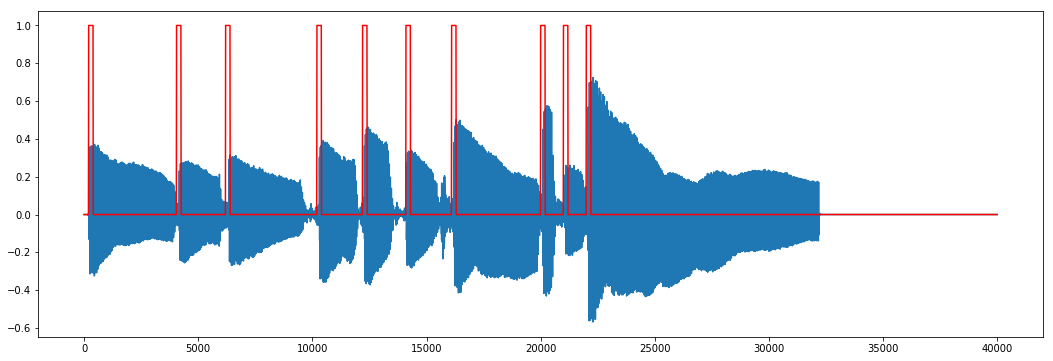

In [12]:
plt.figure(figsize=(18,6))
plt.plot(3*X_train[0])
plt.plot(np.arange(0, length, 10), y_train[0], "r")

In [38]:
np.mean(X_val)

1.5929361404406994e-05

## Model building

In [13]:
def build_model(input_shape):
    X_input = Input(shape=input_shape)
    X = Conv1D(196, kernel_size=10, strides=10)(X_input)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    X = Bidirectional(GRU(units = 128, return_sequences = True))(X)
    X = BatchNormalization()(X)
    X_output = TimeDistributed(Dense(1, activation = "sigmoid"))(X)
    
    return Model(inputs=X_input, outputs=X_output)

In [14]:
model = build_model((length,1))

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40000, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4000, 196)         2156      
_________________________________________________________________
batch_normalization_1 (Batch (None, 4000, 196)         784       
_________________________________________________________________
activation_1 (Activation)    (None, 4000, 196)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4000, 256)         249600    
_________________________________________________________________
batch_normalization_2 (Batch (None, 4000, 256)         1024      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4000, 1)           257       
Total para

## Model training

In [40]:
# from keras import backend as K

# def weighted_bce(y_true, y_pred):
#     weights = (y_true * 15e-6) + 1.
#     bce = K.binary_crossentropy(y_true, y_pred)
#     weighted_bce = K.mean(bce * weights)
#     return weighted_bce

In [41]:
model.compile(Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [42]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('Checkpoints/seg_gru_{val_acc:.2f}.hdf5', verbose=1, monitor='val_acc',
                             save_best_only=True, mode='auto')

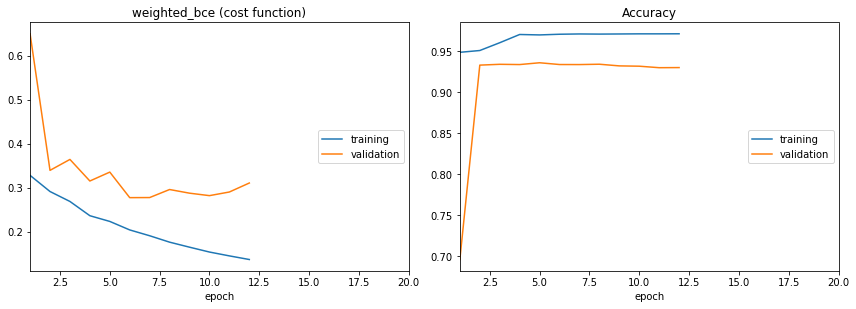

weighted_bce (cost function):
training   (min:    0.137, max:    0.328, cur:    0.137)
validation (min:    0.277, max:    0.650, cur:    0.311)

Accuracy:
training   (min:    0.949, max:    0.971, cur:    0.971)
validation (min:    0.696, max:    0.936, cur:    0.930)

Epoch 00012: val_acc did not improve from 0.93579
Epoch 13/20


KeyboardInterrupt: 

In [43]:
model.fit(X_train, y_train, batch_size=32, epochs=20, 
          validation_data=(X_val, y_val), callbacks=[PlotLossesKeras(), checkpoint])

## Model evaluation

In [44]:
model.load_weights("Checkpoints/seg_gru_0.94.hdf5")

In [45]:
pred = model.predict(X_val)

In [46]:
pred.shape

(35, 4000, 1)

In [47]:
y_pred = (pred >= 0.5).astype(int)

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val.reshape(y_val.shape[0]*y_val.shape[1]), y_pred.reshape(y_pred.shape[0]*y_pred.shape[1]))

In [49]:
cm_norm = np.vstack((cm[0,:]/cm[0,:].sum(), cm[1,:]/cm[1,:].sum()))

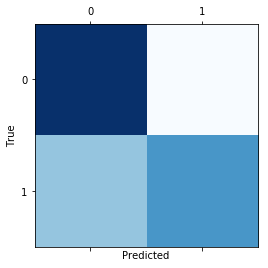

array([[0.97271863, 0.02728137],
       [0.40305233, 0.59694767]])

In [50]:
plt.matshow(cm_norm, cmap=plt.cm.Blues)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
cm_norm

In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_val.reshape(y_val.shape[0]*y_val.shape[1]), y_pred.reshape(y_pred.shape[0]*y_pred.shape[1])))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96    126240
         1.0       0.70      0.60      0.65     13760

   micro avg       0.94      0.94      0.94    140000
   macro avg       0.83      0.78      0.81    140000
weighted avg       0.93      0.94      0.93    140000



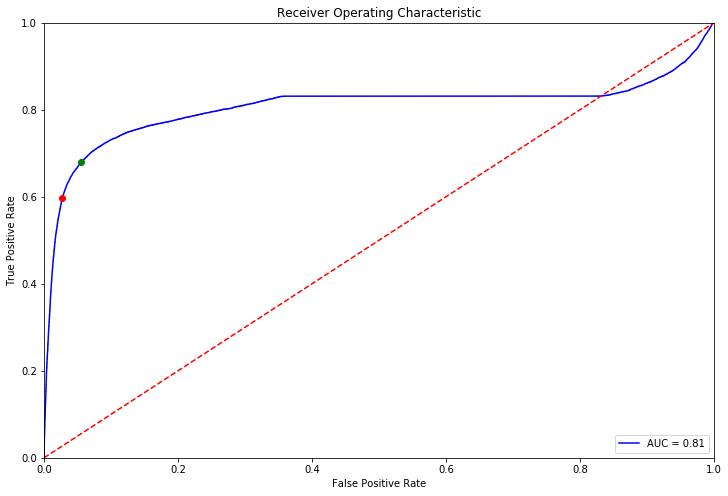

In [52]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_val.reshape(y_val.shape[0]*y_val.shape[1]), pred.reshape(pred.shape[0]*pred.shape[1]))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

thresh_0_5 = np.argmin(np.abs(threshold - 0.5))
plt.plot(fpr[thresh_0_5], tpr[thresh_0_5], "ro")
thresh_0_4 = np.argmin(np.abs(threshold - 0.4))
plt.plot(fpr[thresh_0_4], tpr[thresh_0_4], "go")
plt.show()

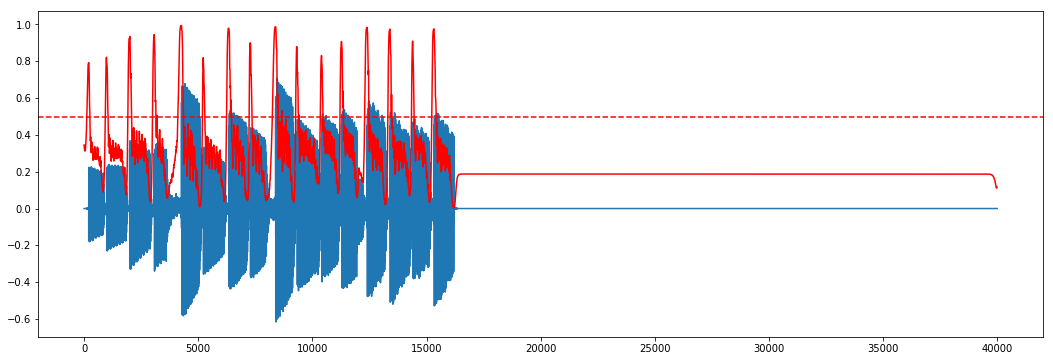

In [55]:
index = np.random.randint(0, X_val.shape[0])
plt.figure(figsize=(18,6))
plt.plot(3*X_val[index])
plt.plot(np.arange(0, length, 10), pred[index], "r")
plt.axhline(0.5, color="r", linestyle="--")